In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Customers').getOrCreate()

In [2]:
from pyspark.ml.regression import LinearRegression

In [3]:
dataset=spark.read.csv("Ecommerce_Customers.csv",inferSchema=True,header=True)

In [4]:
dataset.printSchema()

root
 |-- Email: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- Avg Session Length: double (nullable = true)
 |-- Time on App: double (nullable = true)
 |-- Time on Website: double (nullable = true)
 |-- Length of Membership: double (nullable = true)
 |-- Yearly Amount Spent: double (nullable = true)



In [5]:
dataset.limit(5).toPandas()

,Email,Address,Avg Session Length,Time on App,Time on Website,Length of Membership,Yearly Amount Spent
0,mstephenson@fernandez.com,"835 Frank TunnelWrightmouth, MI 82180-9605",34.497268,12.655651,39.577668,4.082621,587.951054
1,hduke@hotmail.com,"4547 Archer CommonDiazchester, CA 06566-8576",31.926272,11.109461,37.268959,2.664034,392.204933
2,pallen@yahoo.com,"24645 Valerie Unions Suite 582Cobbborough, DC ...",33.000915,11.330278,37.110597,4.104543,487.547505
3,riverarebecca@gmail.com,"1414 David ThroughwayPort Jason, OH 22070-1220",34.305557,13.717514,36.721283,3.120179,581.852344
4,mstephens@davidson-herman.com,"14023 Rodriguez PassagePort Jacobville, PR 372...",33.330673,12.795189,37.536653,4.446308,599.406092


In [27]:
dataset.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
Email,500,None,None,aaron04@yahoo.com,zscott@wright.com
Address,500,None,None,"0001 Mack MillNorth Jennifer, NE 42021-5936",Unit 7502 Box 8345DPO AE 53747
Avg Session Length,500,33.05319351824,0.9925631111602911,29.53242897,36.13966249
Time on App,500,12.052487936928012,0.9942156084624618,8.508152176,15.12699429
Time on Website,500,37.060445421080004,1.0104889068105993,33.91384725,40.00518164
Length of Membership,500,3.5334615559300007,0.9992775024367542,0.26990109,6.922689335
Yearly Amount Spent,500,499.3140382608002,79.31478155115914,256.6705823,765.5184619


Scatter matrix is a great way to roughly determine if we have a linear correlation between multiple independent variables.

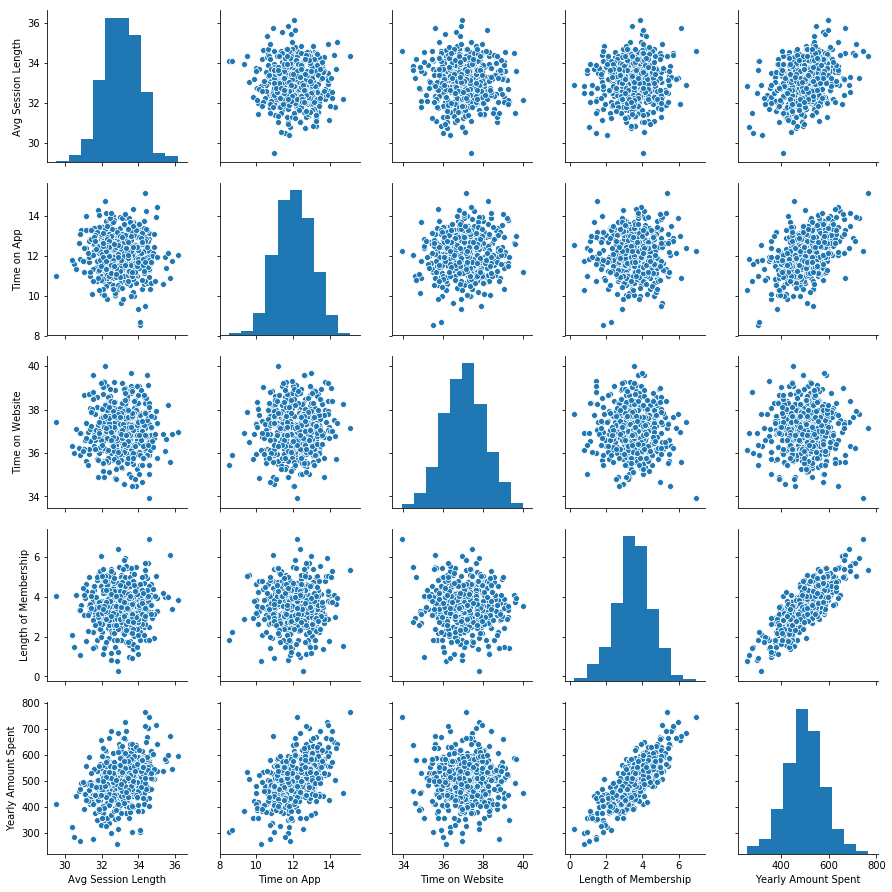

In [35]:
import seaborn as sns

numerical_columns = [i[0] for i in dataset.dtypes if i[1] == 'int' or i[1] == 'double']
numerical_data = dataset.select(numerical_columns).toPandas()

sns.pairplot(numerical_data)

Prepare data for Machine Learning. We will keep all numerical columns except "Yearly amount spent" which will be our dependant variable.

In [7]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [15]:
featureassembler=VectorAssembler(inputCols=["Avg Session Length","Time on App","Time on Website","Length of Membership"],\
                                 outputCol="Independent Features")
output=featureassembler.transform(dataset)
output.limit(5).toPandas()
output.select("Independent Features").show()

,Email,Address,Avg Session Length,Time on App,Time on Website,Length of Membership,Yearly Amount Spent,Independent Features
0,mstephenson@fernandez.com,"835 Frank TunnelWrightmouth, MI 82180-9605",34.497268,12.655651,39.577668,4.082621,587.951054,"[34.49726773, 12.65565115, 39.57766802, 4.0826..."
1,hduke@hotmail.com,"4547 Archer CommonDiazchester, CA 06566-8576",31.926272,11.109461,37.268959,2.664034,392.204933,"[31.92627203, 11.10946073, 37.26895887, 2.6640..."
2,pallen@yahoo.com,"24645 Valerie Unions Suite 582Cobbborough, DC ...",33.000915,11.330278,37.110597,4.104543,487.547505,"[33.00091476, 11.33027806, 37.11059744, 4.1045..."
3,riverarebecca@gmail.com,"1414 David ThroughwayPort Jason, OH 22070-1220",34.305557,13.717514,36.721283,3.120179,581.852344,"[34.30555663, 13.71751367, 36.72128268, 3.1201..."
4,mstephens@davidson-herman.com,"14023 Rodriguez PassagePort Jacobville, PR 372...",33.330673,12.795189,37.536653,4.446308,599.406092,"[33.33067252, 12.79518855, 37.5366533, 4.44630..."


+--------------------+
|Independent Features|
+--------------------+
|[34.49726773,12.6...|
|[31.92627203,11.1...|
|[33.00091476,11.3...|
|[34.30555663,13.7...|
|[33.33067252,12.7...|
|[33.87103788,12.0...|
|[32.0215955,11.36...|
|[32.73914294,12.3...|
|[33.9877729,13.38...|
|[31.93654862,11.8...|
|[33.99257277,13.3...|
|[33.87936082,11.5...|
|[29.53242897,10.9...|
|[33.19033404,12.9...|
|[32.38797585,13.1...|
|[30.73772037,12.6...|
|[32.1253869,11.73...|
|[32.33889932,12.0...|
|[32.18781205,14.7...|
|[32.61785606,13.9...|
+--------------------+
only showing top 20 rows



We only need two columns - "Independant Features" and "Yearly Amount Spent"

In [17]:
finalized_data=output.select("Independent Features","Yearly Amount Spent")
finalized_data.show()

+--------------------+-------------------+
|Independent Features|Yearly Amount Spent|
+--------------------+-------------------+
|[34.49726773,12.6...|         587.951054|
|[31.92627203,11.1...|        392.2049334|
|[33.00091476,11.3...|        487.5475049|
|[34.30555663,13.7...|         581.852344|
|[33.33067252,12.7...|         599.406092|
|[33.87103788,12.0...|        637.1024479|
|[32.0215955,11.36...|        521.5721748|
|[32.73914294,12.3...|        549.9041461|
|[33.9877729,13.38...|         570.200409|
|[31.93654862,11.8...|        427.1993849|
|[33.99257277,13.3...|        492.6060127|
|[33.87936082,11.5...|        522.3374046|
|[29.53242897,10.9...|        408.6403511|
|[33.19033404,12.9...|        573.4158673|
|[32.38797585,13.1...|        470.4527333|
|[30.73772037,12.6...|        461.7807422|
|[32.1253869,11.73...|        457.8476959|
|[32.33889932,12.0...|        407.7045475|
|[32.18781205,14.7...|        452.3156755|
|[32.61785606,13.9...|        605.0610388|
+----------

In [18]:
train_data,test_data=finalized_data.randomSplit([0.75,0.25])

In [19]:
regressor=LinearRegression(featuresCol='Independent Features', labelCol='Yearly Amount Spent')
regressor=regressor.fit(train_data)

In [36]:
regressor.coefficients
regressor.intercept

DenseVector([25.7872, 38.7411, 0.3982, 61.5947])

-1052.4591888216557

In [44]:
trainingsummary = regressor.summary
print("MSE: ", trainingsummary.rootMeanSquaredError)
print("r2: ", trainingsummary.r2)

MSE:  9.916355435486745
r2:  0.9840188518381355


In [25]:
pred_results=regressor.evaluate(test_data)
pred_results.predictions.show(10)

+--------------------+-------------------+------------------+
|Independent Features|Yearly Amount Spent|        prediction|
+--------------------+-------------------+------------------+
|[30.39318454,11.8...|        319.9288698| 331.3684832673632|
|[30.57436368,11.3...|        442.0644138|441.69014240546767|
|[30.81620065,11.8...|        266.0863409|282.84788202218806|
|[30.97167564,11.7...|        494.6386098|  487.703990730947|
|[31.28344748,12.7...|        591.7810894|  569.568985961158|
|[31.52575242,11.3...|        443.9656268|449.32798859240324|
|[31.57413802,12.9...|        544.4092722| 558.6386647830684|
|[31.7207699,11.75...|        538.7749335| 545.6360709105068|
|[31.72165236,11.7...|        347.7769266|349.38330168604534|
|[31.72420252,13.1...|        503.3878873| 509.4841771892045|
+--------------------+-------------------+------------------+
only showing top 10 rows



In [45]:
print("RMSE on test data", pred_results.rootMeanSquaredError)

RMSE on test data 9.949669490873877


In [1]:
# from pyspark.ml.regression import DecisionTreeRegressor
# from pyspark.ml.evaluation import RegressionEvaluator

# dr = DecisionTreeRegressor(featuresCol='Independent Features', labelCol='Yearly Amount Spent')
# dr_model = dr.fit(train_data)
# dr_predictions = dr_model.transform(test_data)
# dr_evaluator = RegressionEvaluator(
#     labelCol="Yearly Amount Spent", predictionCol="prediction", metricName="rmse")
# rmse = dr_evaluator.evaluate(dr_predictions)
# print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)